# Satellite Derived Bathymetry Using a Tuned LightGBM Model for the Lake Mille Lacs Area of Interest

Author: Gregor Beyerle

Date: 2022-06-21

## Overview

This notebook contains the steps taken to perform SDB estimations for the L2A and L1C data products for this AOI. This includes:

- Loading the prepared data
- Setting up training, validation and test data splits
- Performing hyper parameter and model tuning using Optuna
- Evaluating the model

In contrast to the Stumpf Log-Ratio Method which is based on empirical observations and evaluations tuning and fitting a LightGBM model for this use case is solely based on data driven methods. Because I was not able to produce a valid Acolite product for this particular AOI (as mentioned in the [Lake Mille Lacs Dataset Preparation Notebook](./05__dataset_preparation_mille_lacs.ipynb)) I only perform SDB estimations for the L2A and L1C data products.

In [1]:
import sys
import os
import dotenv

from IPython.utils import io

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask
)
from eolearn.ml_tools import TrainTestSplitTask

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from lightgbm import log_evaluation, early_stopping
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import train_test_split

import dalex as dx

This notebook uses functionality of both the `eolearn_extras` module as well as the `sdb_utils` module. It is important to add the relative location of the repository's root directory to the `sys.path` and import `eolearn_extras` before `sdb_utils` as some functions in this module reference `eolearn_extras`.

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
    get_masked_map,
    create_train_val_set,
    write_optuna_capture_to_logs,
)

The data for this project can - depending on whether you work with the complete dataset or only the preprocessed data - be roughly 13 GB on disk. This makes it necessary to distribute data individually from the repository and therefore the location of the data root directory might differ from setup to setup. This repository uses a `.env` file to configure the individual data root directory location. You need to add the `.env` file to your `notebooks` directory and add a line containing the needed information as a line following the pattern `data_root=<path-to-your-data-root>` in order for this notebook to work correctly.

In [3]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

We already prepared the needed data for this AOI in previous notebooks. The first step of the workflow for preparing the train-test-split is to load it from disk.

In [4]:
bahamas_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_sentinel_merged')
)
load_bahamas_eop = LoadTask(bahamas_eop_path)

The eo-learn framework includes a `TrainTestSplitTask` which can be used to create a mask with an arbitrary amount of numerical class (e.g. train, validation and test) labels. For this AOI I decided to use 5% of all possible pixels for training and validation, holding back 95% of the remaining pixels for the final evaluation. I did not want to use more samples because with the AOI not offering a very high degree of variance and the spatial resolution being relatively high, the danger of overfitting appears to be especially pressing. Also, even if in reality a field survey is unlikely to perform a uniform sampling over the whole AOI, I would like to perform an analysis that has some use for people that only have the possibility to survey a limited amount of point tracks when collecting their own calibration data.

In [5]:
data_mask_feature = (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_mask_feature,
    output_feature=train_test_mask_feature,
    bins=[0.025, 0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

The `TrainTestSplitTask` does not itself take an argument for masking out "uninteresting" pixels. Also, it does produce only one mask for all classes, which is - at times - cumbersome to use. I use the `AddValidTrainTestMasks` to combine the bathymetry data mask and the pixel locations of each split to their own masks.

In [6]:
valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_mask_feature
)

The workflow for performing this preparation is comparatively simple as seen in the dependency graph below.

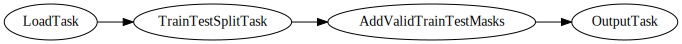

In [7]:
tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_bahamas_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task
)

read_merge_wf = EOWorkflow(nodes)

read_merge_wf.dependency_graph()

Without configuring a random seed to the `TrainTestSplitTask` the pixels in each split would differ with each execution. While this should not impact the analysis it would impair others to repeat the analysis and come to the exact same results. The `seed` argument has to be configured at execution time. To do this in the context of a workflow rather than a simple task execution we can find the `EONode` reference in the list of nodes which was implicitly created for us when we executed the `linearly_connected_tasks` function.

After executing the workflow we can see that we now have the required masks as well as some additional information in the `meta_info` that helps to gain an intuition for the magnitude of each supported split.

In [8]:
train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=float32)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
    validation_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
  }
  meta_info={
    test_count: 4880210
    test_perc: 0.9500677186137317
    train_count: 128468
    train_perc: 0.02500984582115706
    validation_count: 128019
    validation_perc: 0.0249224355651112
  }
  bbox=BBo

To get a better idea how the samples are distributed per split we can have a look at the created maps. Below we can see the split for training data as an example.

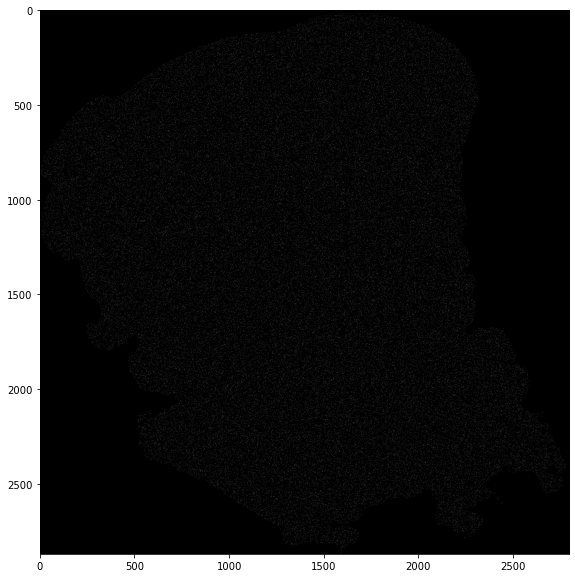

In [9]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False, stretch=False)
plt.show()

## Performing SDB on the Basis of L2A Data

In contrast to the empirical Stumpf Log-Ratio model where we can follow an intuitive formula to prepare the most significant band information and use that to fit a linear regression model without any hyper parameters there are more elements to calibrate in a regression problem when using LightGBM. LightGBM is a machine learning library that allows us to build models on the basis of gradient boosted trees. On this basis we can model non-linear relationships and effects between different attributes while also working with large amount of data (Ke et al., 2017). To get the best results I plan to use the Optuna hyperparameter optimization framework (Akiba et al., 2019) to choose the best combination of hyper parameters for a given AOI.

LightGBM works best with `DataSet` objects that allow very efficient access for training a large amount of decision trees.

In [10]:
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2A_data'))

I use the `optuna.integration.lightgbm` module as a drop-in replacement for the standard LightGBM python module. This has the positive effect of full Optuna integration while still being very close to the standard LightGBM API.

I configure the model for a regression task using the mean squared error as the the error metric. I set a random seed because LightGBM uses randomness in the process of building the gradient boosted trees and I would like to deterministically produce the same results for each time this experiment is rerun.

In theory a LightGBM model could train for an arbitrarily large amount of iterations. When doing that on a training data set the results will - with enough time - most likely approach optimal scores for this exact set of data, leading to severe overfitting. I configure an early stopping callback that stops the training of a model if there hasn't been any improvement on the validation data set (improvements in the training data set are ignored) for 100 iterations.

As Optuna and LightGBM can get rather verbose with their outputs I configure a Jupyter Notebook capture for outputs that might still be interesting for debugging and optimization diagnosis.

In [11]:
params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'seed': 42,
}

with io.capture_output() as capture:
    model_l2a = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-06-22 00:11:10,971] A new study created in memory with name: no-name-686dec0f-0c5a-4561-b4db-3e18f5e70f55
[I 2022-06-22 00:11:14,559] Trial 0 finished with value: 1.71755120723609 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 1.71755120723609.
[I 2022-06-22 00:11:18,885] Trial 1 finished with value: 1.7077309027728897 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 1.7077309027728897.
[I 2022-06-22 00:11:23,452] Trial 2 finished with value: 1.7077309027728897 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 1.7077309027728897.
[I 2022-06-22 00:11:27,819] Trial 3 finished with value: 1.7077309027728897 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 1.7077309027728897.
[I 2022-06-22 00:11:31,744] Trial 4 finished with value: 1.7077309027728897 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 1.7077309027728897.
[I 2022-06-22 00:11:36,039] Trial 5 fini

After the optimization process we can extract the parameters for the Optuna study. The Optuna LightGBM integration is configured to tune the `lambda_l1`, `lambda_l2`, `num_leaves`, `feature_fraction`, `bagging_fraction` and `bagging_freq` parameters of the model using a Tree-structured Parzen Estimator (TPE) sampling algorithm. I set a fixed random seed for this process because the `TPESampler` is based on probabilistic models and therefore can produce different results for each study run (Akiba et al., 2019).

In [12]:
best_params = model_l2a.params
best_params

{'objective': 'regression',
 'metric': 'l2',
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 7.747577106473336,
 'lambda_l2': 3.404677878190547e-05,
 'num_leaves': 244,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': None}

As we are estimating pixel values for a bathymetry map we can generate estimates for the whole map to visualize the model output. In the below cell we retrieve all valid explanatory data to produce a completely estimated map. While the result is still far grainier than the base-truth bathymetry map we can see a picture that has managed to capture some of the structures we didn't pick up when using the Stumpf model. Especially the shallower regions near the south shore of the lake greatly improved.

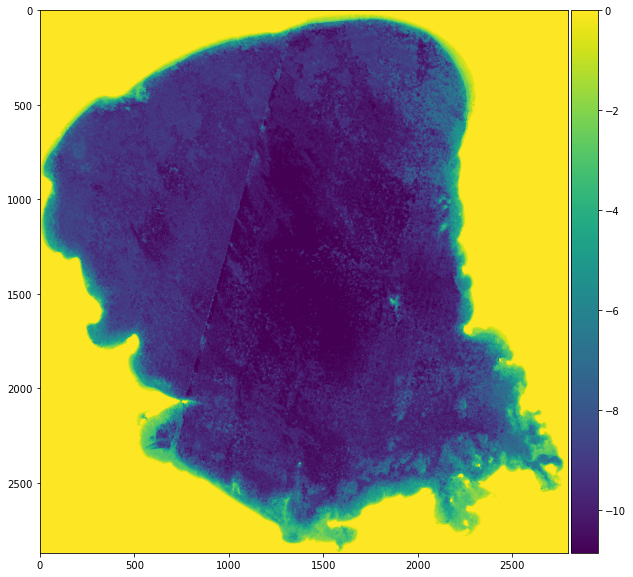

In [13]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(
    train_test_eop,
    model_l2a,
    X_all,
    mask_feature=data_mask_feature
)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

The deviation map shows the striking differences from its counterpart derived from the Stumpf model estimates. While both models have not managed to pick up the crevasses in the north-western quadrant we can observe that some structures have been picked up, the shoreline is less error prone and the deviations in the lake area are far noisier.

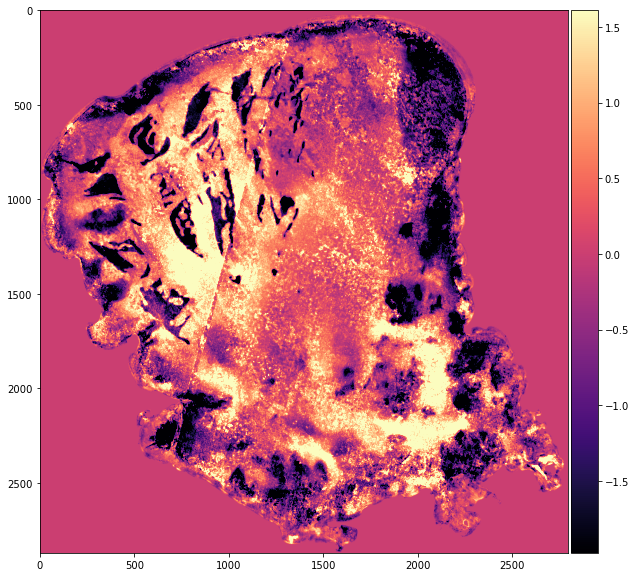

In [14]:
masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l2a_sdb_errors = l2a_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

From the distribution of residuals we can see a narrower, more symmetric picture than we would in the Stumpf example. We can also observe that the distribution appears to be denser in the region of smaller deviations. Additionally, the extremely long tail with positive deviations completely vanished.

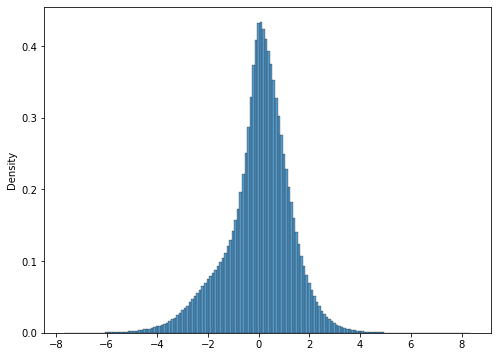

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

One of the more obvious drawbacks of using a tuned LightGBM model is that it is harder to reason about it. The regression metrics show impressive improvements over the Stumpf model but in contrast to a linear regression which can be easily interpreted and statistically tested for validity we have to use other methods for further inspection. At the end of this notebook I will use the dalex framework (Baniecki et al., 2021) for a brief exploration.

In [18]:
X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

X_test_subsample, _, y_test_subsample, _ = train_test_split(X_test, y_test, train_size=100000, random_state=42)
exp_lgbm_l2a = dx.Explainer(model_l2a, X_test_subsample, y_test_subsample, label='lgbm_tuned_l2a', verbose=False)
exp_lgbm_l2a.model_performance()

,mse,rmse,r2,mae,mad
lgbm_tuned_l2a,1.660154,1.28847,0.775724,0.956453,0.709616


## Performing SDB on the Basis of L1C Data

After performing the analysis on the basis of the L2A dataset we can now tune a model on the basis of the alternative data extracted from the L1C product. As the process remains mostly the same with the difference that we are using a different set of values for the training data set I will omit the explanation of the details as well as the discussion of the results until we reach the comparative evaluation.

In [19]:
# retrieve L1C training and validation data sets
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L1C_data'))

# tune lgbm model for L1C data
with io.capture_output() as capture:
    model_l1c = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

# retrieve L1C complete input and label data
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

# estimate L1C SDB values for complete data set
l1c_sdb_estimation_values, _ = create_sdb_estimation(
    train_test_eop,
    model_l1c,
    X_all,
    data_mask_feature
)

# compute residuals for complete data set
l1c_sdb_residuals = l1c_sdb_estimation_values - y_all

# prepare explainer for L1C model on a subsample of the test set
X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_test_subsample, _, y_test_subsample, _ = train_test_split(X_test, y_test, train_size=100000, random_state=42)
exp_lgbm_l1c = dx.Explainer(model_l1c, X_test_subsample, y_test_subsample, label='lgbm_tuned_l1c', verbose=False)

[I 2022-06-22 00:26:07,946] A new study created in memory with name: no-name-a44a54df-653a-4175-a15e-38ea2316df99
[I 2022-06-22 00:26:13,309] Trial 0 finished with value: 1.7922183844476733 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 1.7922183844476733.
[I 2022-06-22 00:26:18,553] Trial 1 finished with value: 1.8104197830196185 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.7922183844476733.
[I 2022-06-22 00:26:23,839] Trial 2 finished with value: 1.78587846539596 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 1.78587846539596.
[I 2022-06-22 00:26:28,544] Trial 3 finished with value: 1.834746715741467 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 1.78587846539596.
[I 2022-06-22 00:26:33,273] Trial 4 finished with value: 1.8032019287728158 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 1.78587846539596.
[I 2022-06-22 00:26:38,272] Trial 5 finished 

## Evaluation of SDB Results

Looking at the raw performance metrics we see that both models are almost interchangeable regarding their performance metrics. We can also see that the performance increased rapidly in comparison to the calibrated Stumpf Log-Ratio model for this region.

In [21]:
exp_list = [exp_lgbm_l1c, exp_lgbm_l2a]
pd.concat([exp.model_performance().result for exp in exp_list])

,mse,rmse,r2,mae,mad
lgbm_tuned_l1c,1.750280,1.322981,0.763549,0.981790,0.729244
lgbm_tuned_l2a,1.660154,1.288470,0.775724,0.956453,0.709616


Overlaying the residuals confirms that there is very little difference in the performance of the individual models.

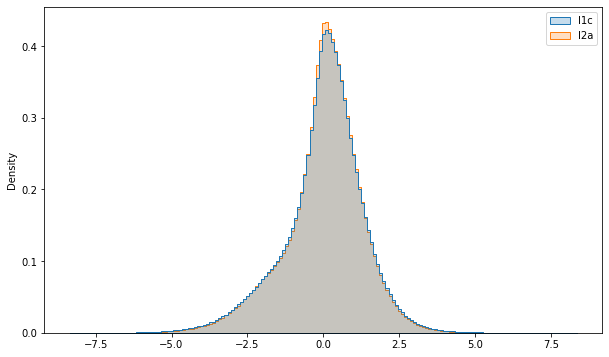

In [22]:
residuals_df = pd.DataFrame({
    'l1c': l1c_sdb_residuals,
    'l2a': l2a_sdb_residuals,
})

plt.figure(figsize=(10, 6))
sns.histplot(residuals_df, binwidth=0.1, stat='density', element='step', common_norm=False)
plt.show()

An alternative perspective on the global performance of the models with respect to the reverse cumulative distribution of the absolute residuals. Here it becomes even more visible that the L1C and L2A based models are very close in regards to their residual distributions.

In [23]:
fig = exp_list[0].model_performance().plot([exp.model_performance() for exp in exp_list[1:]], show=False)
fig.write_image('../figures/plotly_exports/12__rev_cum_dist_res.png', format='png', engine='orca')

![reverse cumulative distribution of absolute residuals](../figures/plotly_exports/12__rev_cum_dist_res.png)

In the Stumpf Log-Ratio model we know exactly that we are either looking at the red and blue or green and blue bands to come to a bathymetry estimate. The exact mathematical relationship can be inferred by extracting the $m_0$ and $m_1$ parameters and inspecting the resulting function. With large ensemble models based on gradient boosted trees we could theoretically also inspect each tree, each split and each weight but this hardly leads to the same intuition.

With dalex we can inspect the importance each variable has for coming to an estimate in relation to all other variables. For this AOI we can see that variables with the index values 2, 0, 9 and 7 (corresponding with the green, coastal aerosol, water vapour, and NIR bands respectively) have the greatest influence on the estimate. Especially the green and coastal aerosol appear to have the biggest impact, which could be explained by the ratio of blue and green working well to estimate water depths below 6 meters and above 25 meters of depth (Cabarello and Stumpf, 2019). The coastal aerosol band has a central wavelength of around 440 nm which corresponds to violets and deep blues in the visual spectrum and - as already indicated by its name - is often used for observing coastal regions which can be more turbid than regions with greater distance to the shore.

In [24]:
fig = exp_list[0].model_parts().plot([exp.model_parts() for exp in exp_list[1:]], show=False)
fig.write_image('../figures/plotly_exports/12__variable_importance.png', format='png', engine='orca')

![variable importance plot](../figures/plotly_exports/12__variable_importance.png)

Because those bands have the greatest impact on the bathymetry estimate it makes sense to look at their respective partial dependence plots. In those we can see, that the different models show similar responses for the bands with the L1C band being shifted by a certain difference in reflectance. This makes sense because the L2A model was trained on data that was produced by applying atmospheric correction. When preparing the dataset we looked at the histograms of the red, green and blue bands where this shift was also clearly visible.

In [25]:
fig = exp_list[0].model_profile(variable_splits_type="quantiles").plot(
    [exp.model_profile(variable_splits_type="quantiles") for exp in exp_list[1:]],
    variables=['2', '0', '9', '7'],
    title="Partial Dependence",
    show=False,
)
fig.write_image('../figures/plotly_exports/12__partial_dependence.png', format='png', engine='orca', width=800)

Calculating ceteris paribus: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


![partial dependence plot](../figures/plotly_exports/12__partial_dependence.png)